# Compare quadrature schemes

The numeric solution of the [homogeneous Fredholm equation of second kind](https://en.wikipedia.org/wiki/Fredholm_integral_equation#Equation_of_the_second_kind) involves the discretization of an integral.
Here we investigate the influence of different quadrature schemes on the numerical accuracy with respect
to the [Karhunen-Loeve expansion of stochastic processes](https://en.wikipedia.org/wiki/Kosambi%E2%80%93Karhunen%E2%80%93Lo%C3%A8ve_theorem).

In [1]:
import stocproc
from functools import partial
import matplotlib.pyplot as plt
import mppfc
import numpy as np
from scipy.linalg import eigh as scipy_eigh

In [2]:
def ohmic_bcf(tau, s):
    return 1 / (1 + 1j*tau)**(s+1)

In [3]:
@mppfc.CacheFileBasedDec(include_module_name=False)
def sol_Fredholm(acf, t_max, ng, quad_scheme, idx):
    quad_meth = stocproc.method_kle.str_meth_to_meth(quad_scheme)
    
    small_weights_problem = (quad_meth is stocproc.method_kle.get_nodes_weights_tanh_sinh)
    
    t, w, is_equi = quad_meth(
        t_max=t_max,
        num_grid_points=ng
    )

    acf_matrix = stocproc.method_kle._calc_corr_matrix(
        s = t,
        acf = acf,
        is_equi=is_equi,
    )

    eig_val, eig_vec = stocproc.method_kle.solve_hom_fredholm(
        r = acf_matrix,
        w = w,
        small_weights_problem=small_weights_problem
    )
    
    if idx == 'all':
        return t, w, eig_val, eig_vec
    
    return t, w, eig_val[idx], eig_vec[:, idx]

## Solve Homogeneous Fredholm Equation

The integral equation

$$ \int_0^T \mathrm{d}s \, \alpha(t-s) u_k(s) = \lambda_k u_k(t) $$

becomes in numerically digestable form

$$ \sum_{j=1}^M w_j \alpha(t_i - t_j) u_k(s_j) = \lambda_k u_k(t_i) $$

where $t_i$ and $w_i$ are the nodes and weights of some quadrature scheme.
One is, thus, left with an eigenvalue problem.
Following "Numerical Recipes" (Cambridge University Press) this is conveniently rewritten to
maintain the Hermician property of the integral kernen $\alpha$ as

$$ \tilde R_{ij} \tilde u_j = \lambda \tilde u_i $$

with $\tilde R_{ij} = D  \alpha(t_i - t_j) D$, $\tilde u = D u$ and $D$ being 
the diagonal Matrix $D_{ij} = \sqrt{w_i} \delta_{ij}$.
So, since $\alpha(t_i - t_j)$ is Hermician, $\tilde R_{ij}$ is Hermician and, thus, $\lambda$ is real.
If the eigenvectors $\tilde u$ are normed to unity, i.e., $\sum_i |\tilde u_i|^2 = 1$, 
the eigenfunction (their discrete approximation) are normed to unity as well in terms of the integral norm

$$
1 = \sum_i |\tilde u_i|^2 = \sum_i w_i |u_i|^2 \approx \int_0^T \mathrm{d} t \, |u(t)|^2
$$

In [4]:
# as implemented in stocproc.method_kle.solve_hom_fredholm

for quad_scheme in [
    'midpoint',
    'simpson',
    'fourpoint',
    'gauss_legendre',
    'tanh_sinh',
]:
    print("use quad scheme", quad_scheme)
    t_max = 30
    ng = 65
    acf = partial(ohmic_bcf, s=1)

    # prepare quadrature scheme
    quad_meth = stocproc.method_kle.str_meth_to_meth(quad_scheme)    
    t, w, is_equi = quad_meth(
        t_max=t_max,
        num_grid_points=ng
    )
    # contruct correlation matrix on the quadrature nodes
    acf_matrix = stocproc.method_kle._calc_corr_matrix(
        s = t,
        acf = acf,
    )
    # set up the Hermician eigenvalue problem
    w_sqrt = np.sqrt(w)
    DrD = w_sqrt.reshape(ng, 1) * acf_matrix * w_sqrt.reshape(1, ng)
    eig_val, eig_vec_tilde = scipy_eigh(DrD)

    # reconstruct the auto correlation matrix
    DrD_prime = np.einsum('k, ik, jk', eig_val, eig_vec_tilde, eig_vec_tilde.conj())

    # this should be zero, otherwise scipy screws up
    d = np.abs(DrD - DrD_prime)
    print("  reconstruct 'DrD' -> eps = {:.4e}".format(np.max(d)))

    # change order from acending to decending
    eig_val = eig_val[::-1]
    eig_vec_tilde = eig_vec_tilde[:, ::-1]

    # convert the rephrased eigenvalue problem back to the original setting 
    #
    # !!!
    #     this becomes probelmatic for small weights w, as for the tanh-sinh quadrature
    eig_vec = np.reshape(1 / w_sqrt, (ng, 1)) * eig_vec_tilde

    # reconstruct the original auto correlation matrix
    r_prime = np.einsum('k, ik, jk', eig_val, eig_vec, eig_vec.conj())
    d = np.abs(acf_matrix-r_prime)
    print("  reconstruct 'r'   -> eps = {:.4e}".format(np.max(d)))
    print("  max_i 1/sqrt(w_i) = {:.4e}".format(np.max(1/w_sqrt)))
    
    eig_vec_2 = np.einsum('ij, j, k, jk -> ik', acf_matrix, w_sqrt, 1/eig_val, eig_vec_tilde)
    r_prime_2 = np.einsum('k, ik, jk', eig_val, eig_vec_2, eig_vec_2.conj())
    d = np.abs(acf_matrix-r_prime_2)
    print("  reconstruct v2 'r'-> eps = {:.4e}".format(np.max(d)))
    norm = np.sum(w.reshape(-1, 1) * np.abs(eig_vec_2)**2, axis=(0, ))
    print("  norm:", norm)


use quad scheme midpoint
  reconstruct 'DrD' -> eps = 2.2239e-15
  reconstruct 'r'   -> eps = 4.6781e-15
  max_i 1/sqrt(w_i) = 1.4606e+00
  reconstruct v2 'r'-> eps = 4.8472e-15
  norm: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
use quad scheme simpson
  reconstruct 'DrD' -> eps = 2.6002e-15
  reconstruct 'r'   -> eps = 4.9960e-15
  max_i 1/sqrt(w_i) = 2.5298e+00
  reconstruct v2 'r'-> eps = 5.1070e-15
  norm: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
use quad scheme fourpoint
  reconstruct 'DrD' -> eps = 2.3609e-15
  reconstruct 'r'   -> eps = 4.2189e-15
  max_i 1/sqrt(w_i) = 2.6186e+00
  reconstruct v2 'r'-> eps = 3.6938e-15
  norm: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

**Observation**: The small weights of the **tanh-sinh quadrature scheme** appear to be the reason why the auto correlation matrix cannot be recovered with high numeric accuracy!

**Observation 2**: instead of recovering $u_i = \tilde u_i / \sqrt{w_i}$ we can use
$u_i = \frac{1}{\lambda} \sum_j \alpha(t_i - t_j) \sqrt{w_j} \tilde u_j$ which circumvents the devision by $\sqrt{w_i}$ (square root of the weights). We still have to devide by the eigen values, but the tests show that this expression is highly advantegeous  for the tanh-sinh scheme!

**Observation 3**: well that screws the norm for the larger indices

## Plot Eigenfunctions, Auto-Correlation Function and the Spectrum with High Precision

Calculate the eigenfunctions on a fine grid using mid point quadrature,
so one can get an impression what we are lokking for.
Show also the eigenvalue (spectrum).

norm u_0 = 1.0000e+00
norm u_3 = 1.0000e+00
norm u_15 = 1.0000e+00
norm u_0 = 1.0000e+00
norm u_3 = 1.0000e+00
norm u_15 = 1.0000e+00


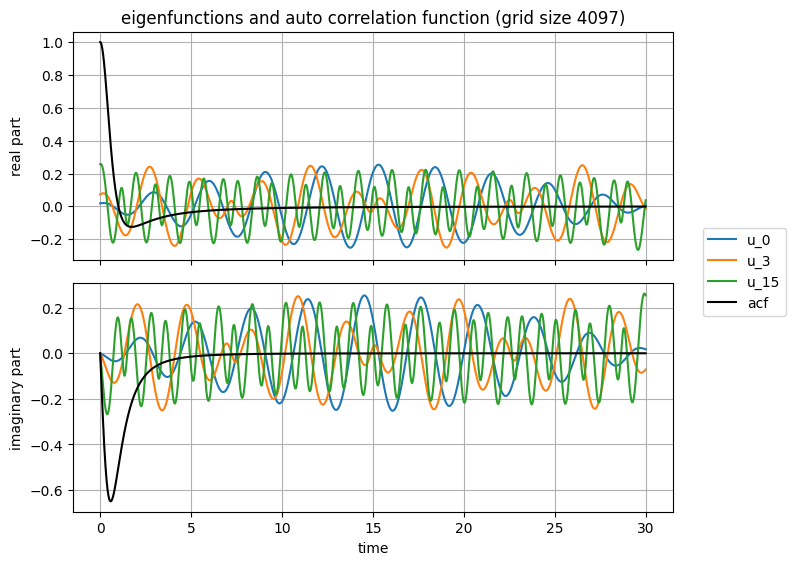

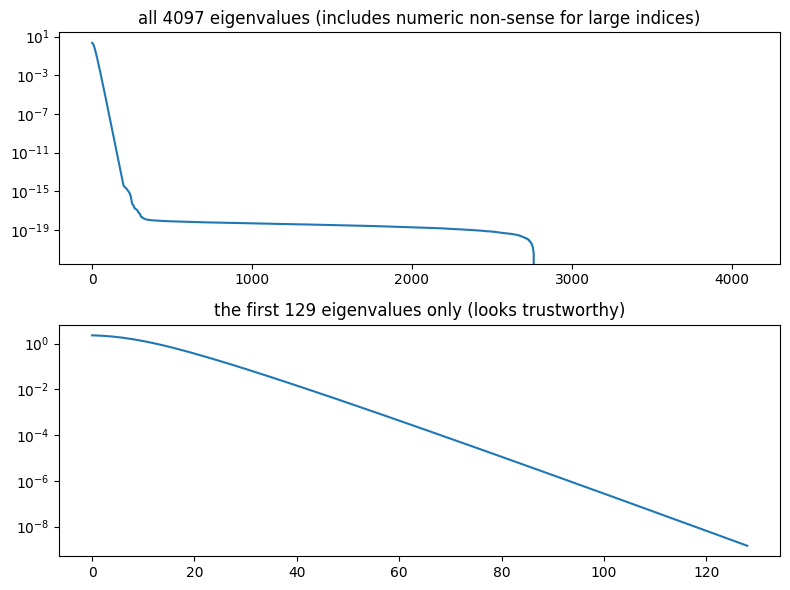

In [5]:
t_max = 30
s = 1
acf = partial(ohmic_bcf, s=s)

ng_ref = 2**12+1

t_ref, w, eig_val_ref, eig_vec_ref = sol_Fredholm(
    acf = acf,
    t_max = t_max,
    ng = ng_ref,
    quad_scheme = 'midpoint',
    idx = 'all',
)

fig, ax = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

for j, part in enumerate([('real', np.real), ('imaginary', np.imag)]):
    axc = ax[j]
    
    part_name, part_fnc = part

    for i in [0, 3, 15]:
        phase = np.exp(1j*np.angle(eig_vec_ref[:, i]))
        axc.plot(t_ref, part_fnc(phase*eig_vec_ref[:, i]), label=f"u_{i}")
        
        norm_eig_vec = np.sum(w*np.abs(eig_vec_ref[:, i])**2)
        print(f"norm u_{i} = {norm_eig_vec:.4e}")
    
    axc.plot(t_ref, part_fnc(acf(t_ref)), color='k', label="acf")
    axc.set_ylabel(f"{part_name} part")
    axc.grid()
    
ax[0].legend(
    loc='center right',
    bbox_to_anchor=(1, 0.5),
    bbox_transform=fig.transFigure,
)
ax[0].set_title(f"eigenfunctions and auto correlation function (grid size {ng_ref})")
ax[-1].set_xlabel("time")
fig.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, hspace=0.1)
fig.savefig("eigf_acf.jpg", dpi=300)

fig, ax = plt.subplots(nrows=2, figsize=(8, 6))

ax[0].set_title(f"all {ng_ref} eigenvalues (includes numeric non-sense for large indices)")
ax[0].plot(eig_val_ref)
ax[0].set_yscale('log')

idx_max = 129
ax[1].set_title(f"the first {idx_max} eigenvalues only (looks trustworthy)")
ax[1].plot(eig_val_ref[:idx_max])
ax[1].set_yscale('log')

fig.tight_layout()


## Eigenfunction Approximation - Solutions to the Discrete Fredholm Equation

Question: how can we keep the grid size as small as possible? Or the other way around, for a given grid size, how can we best approximate the eigenfunctions?

* change number of grid points used for the discretization
* use different quadature schemes

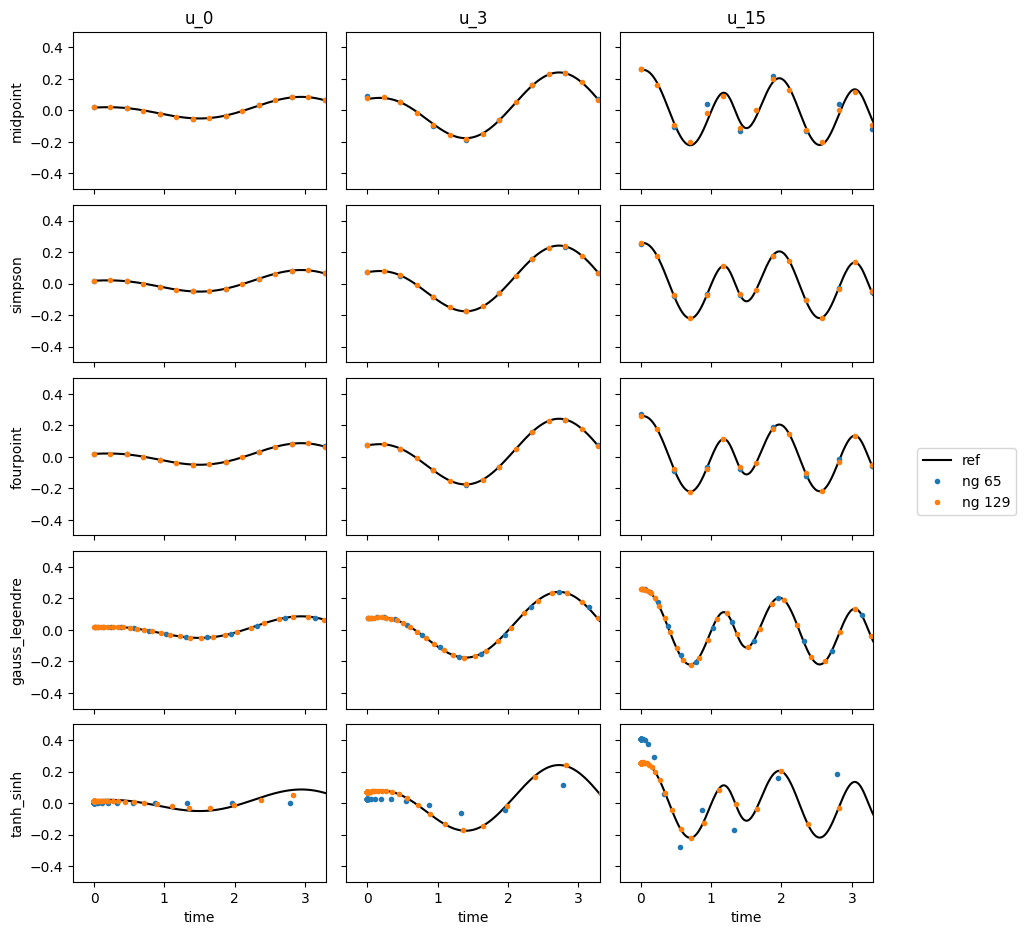

In [6]:
t_max = 30
s = 1
acf = partial(ohmic_bcf, s=s)

idx = [0, 3, 15]

ng_ref = 2**12+1

t_ref, w, eig_val_ref, eig_vec_ref = sol_Fredholm(
    acf = acf,
    t_max = t_max,
    ng = ng_ref,
    quad_scheme = 'midpoint',
    idx = idx
)


methods = [
    'midpoint',
    'simpson',
    'fourpoint',
    'gauss_legendre',
    'tanh_sinh',
]

fig, ax = plt.subplots(
    ncols=len(idx),
    nrows=len(methods),
    figsize=(10, 10), 
    sharex=True,
    sharey=True,
)

for i, m in enumerate(methods):
    ax[i, 0].set_ylabel(m)
    for j, ii in enumerate(idx):
        axc = ax[i, j]
        if i == 0:
            axc.set_title(f"u_{ii}")
            ax[-1, j].set_xlabel("time")


        phase = np.exp(1j*np.angle(eig_vec_ref[:, j]))
        axc.plot(t_ref, np.real(phase*eig_vec_ref[:, j]), label=f"ref", color='k')
    

        for ng in [65, 129]:
            t, w, eig_val, eig_vec = sol_Fredholm(
                acf = acf,
                t_max = t_max,
                ng = ng,
                quad_scheme = m,
                idx = idx,
                _cache_flag='no_cache',  # ng is small -> this is fast
            )
            phase = np.exp(1j*np.angle(eig_vec[:, j]))
            axc.plot(t, np.real(phase*eig_vec[:, j]), label=f"ng {ng}", marker='.', ls='')

axc.set_xlim([-0.3, 3.3])
axc.set_ylim([-0.5, 0.5])
axc.legend(
    bbox_to_anchor=(1, 0.5),
    bbox_transform=fig.transFigure,
    loc='center right'
)

fig.subplots_adjust(left=0.05, right=0.85, bottom=0.1, top=0.95, hspace=0.1, wspace=0.08)

**Conclusion:** There appears to be no advantage of the more advanced quadrature schemes on the level of the above visual impression.

One can also see that with increasing index, the eigenfunction oscillate faster. Therefore a sufficiently fine grid is needed to trustworthly interpolate between the grid points.

## Absolute Error of the Eigenfunctions

For a more quantitatve judgement show the absolute error between the eigenfunction approximations obtained using a rough grid and the reference eigenfunctions (super fine grid).

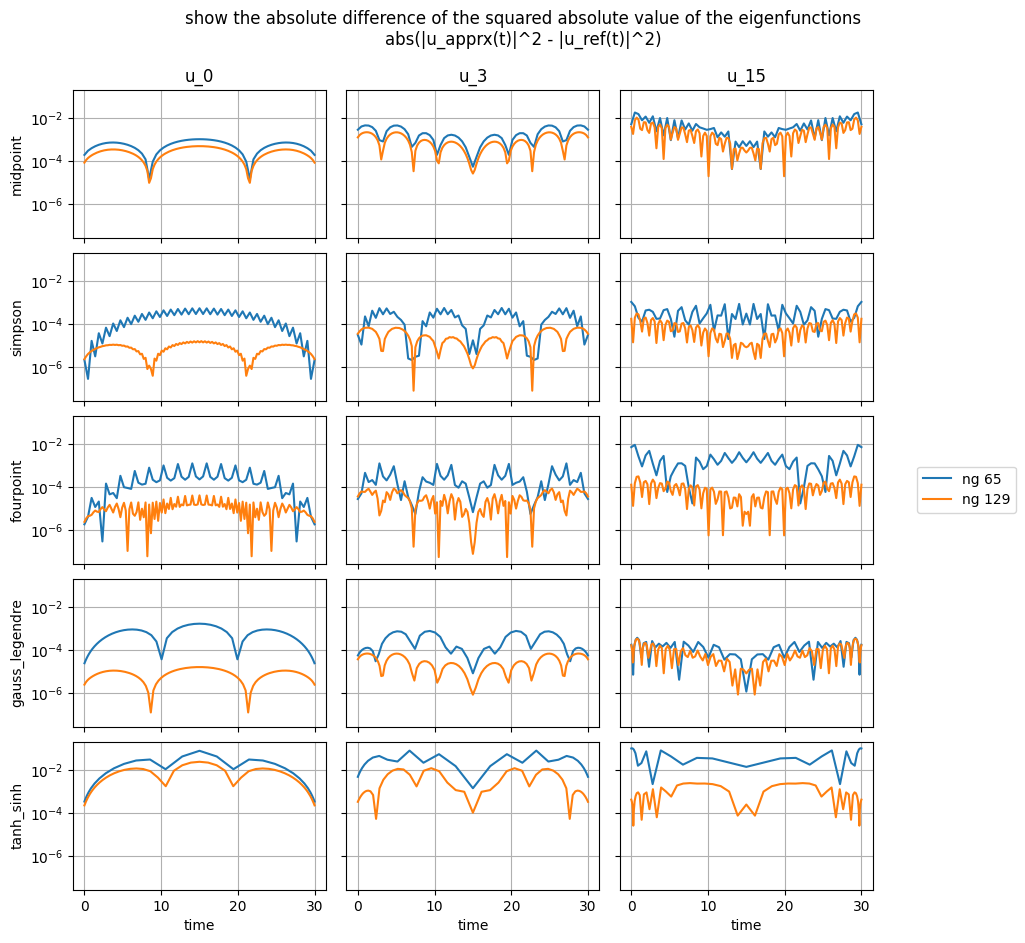

In [7]:
t_ref, w, eig_val_ref, eig_vec_ref = sol_Fredholm(
    acf = acf,
    t_max = t_max,
    ng = ng_ref,
    quad_scheme = 'midpoint',
    idx = idx
)

methods = [
    'midpoint',
    'simpson',
    'fourpoint',
    'gauss_legendre',
    'tanh_sinh',
]

fig, ax = plt.subplots(
    ncols=len(idx),
    nrows=len(methods),
    figsize=(10, 10), 
    sharex=True,
    sharey=True,
)

for i, m in enumerate(methods):
    ax[i, 0].set_ylabel(m)
    for j, ii in enumerate(idx):
        axc = ax[i, j]
        if i == 0:
            axc.set_title(f"u_{ii}")
            ax[-1, j].set_xlabel("time")

        ev_intp = stocproc.util.ComplexInterpolatedUnivariateSpline(
            x=t_ref,
            y=eig_vec_ref[:, j],
            noWarning=True,
        )
    
        for ng in [65, 129]:
            t, w, eig_val, eig_vec = sol_Fredholm(
                acf = acf,
                t_max = t_max,
                ng = ng,
                quad_scheme = m,
                idx = idx,
                _cache_flag='no_cache', # ng is small -> this is fast
            )
            diff_t = np.abs(np.abs(eig_vec[:, j])**2 - np.abs(ev_intp(t))**2)
            axc.plot(t, diff_t, label=f"ng {ng}")
        axc.set_yscale('log')
        axc.grid()

#axc.set_xlim([-0.3, 5.3])
#axc.set_ylim([-0.05, 0.3])
axc.legend(
    bbox_to_anchor=(1, 0.5),
    bbox_transform=fig.transFigure,
    loc='center right'
)

fig.suptitle(
    "show the absolute difference of the squared absolute value of the eigenfunctions\n"+
    "abs(|u_apprx(t)|^2 - |u_ref(t)|^2)"
)

fig.subplots_adjust(left=0.05, right=0.85, bottom=0.1, top=0.9, hspace=0.1, wspace=0.08)

**Conclusion:** Simpson, fourpoint and Gauss-Legendre outperform midpoint and tanh-sinh.

## Reconstruction of the Auto-Correlation Function, Convergence with the Number of Eigenfunctions

For numerics, using the Karhunen-Loeve expansion we express a Gaussian stochastic proccess by the **finite** sum

$$ z(t) = \sum_{i=1}^n Z_i \sqrt{\lambda_i} u_i(t) $$

which yields the auto correlation function

$$ \langle z(t) z^\ast(s) \rangle = \sum_{i=1}^n \lambda_i u_i(t) u_i^\ast(s) \approx \alpha(t-s) $$

if $Z_i$ are independent complex valued Gaussian random variables with $\langle Z_i Z^\ast_j \rangle = \delta_{ij}$.

So we analyse the error as a function of the number of expantion terms for different quadrature schemes and different grid sizes,

$$ \epsilon(n) = \max_{t,s} \Big|\sum_{i=1}^n \lambda_i u_i(t) u_i^\ast(s) - \alpha(t-s)\Big| $$

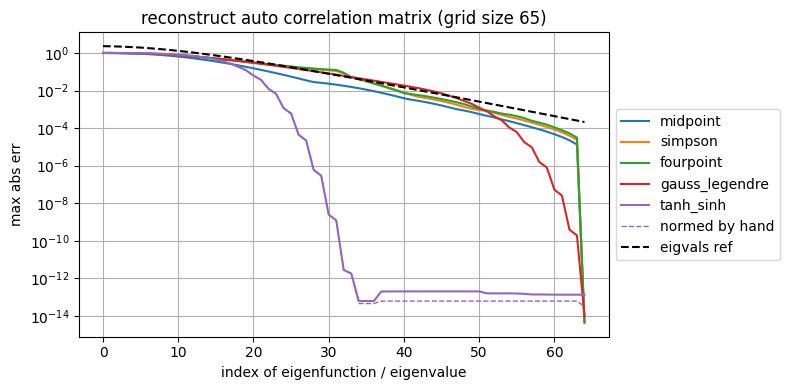

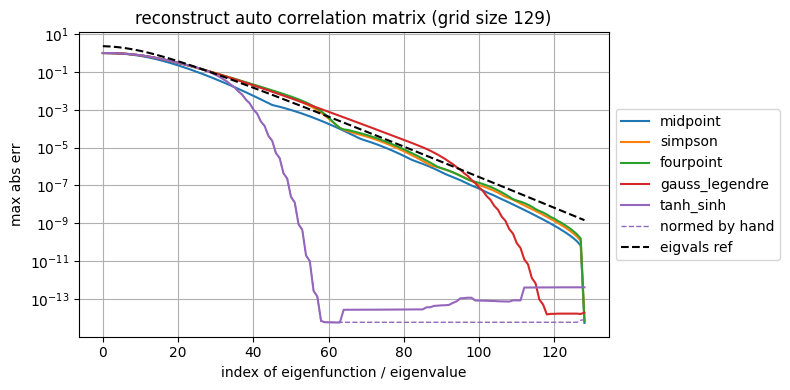

In [8]:
methods = [
    'midpoint',
    'simpson',
    'fourpoint',
    'gauss_legendre',
    'tanh_sinh',
]

t_ref, w, eig_val_ref, eig_vec_ref = sol_Fredholm(
    acf = acf,
    t_max = t_max,
    ng = ng_ref,
    quad_scheme = 'midpoint',
    idx = 'all',
)

for ng in [65, 129]:

    fig, ax = plt.subplots(
        ncols=1,
        nrows=1,
        figsize=(8, 4), 
        sharex=True,
        sharey=True,
    )

    axc = ax
    for i, m in enumerate(methods):
        t, w, eig_val, eig_vec = sol_Fredholm(
            acf = acf,
            t_max = t_max,
            ng = ng,
            quad_scheme = m,
            idx = 'all',
            _cache_flag='no_cache', # ng is small -> this is fast
        )
        acf_matrix = stocproc.method_kle._calc_corr_matrix(s=t, acf=acf)
        acf_accum = np.zeros(shape=(ng, ng), dtype=np.complex128)
        acf_accum_normed = np.zeros(shape=(ng, ng), dtype=np.complex128)
        k_data = list(range(ng))
        max_diff_data = []
        max_diff_data_normed = []
        for k in k_data:
            acf_accum += eig_val[k]*eig_vec[:, k].reshape(-1, 1) * eig_vec.conj()[:, k].reshape(1, -1)
            max_diff = np.max(np.abs(acf_accum - acf_matrix))
            max_diff_data.append(max_diff)
            
            norm = np.sum(w * np.abs(eig_vec[:, k])**2)
            acf_accum_normed += eig_val[k]*eig_vec[:, k].reshape(-1, 1) * eig_vec.conj()[:, k].reshape(1, -1) / norm
            max_diff_normed = np.max(np.abs(acf_accum_normed - acf_matrix))
            max_diff_data_normed.append(max_diff_normed)
        p, = axc.plot(k_data, max_diff_data, label=m)
        if m == 'tanh_sinh':
            axc.plot(k_data, max_diff_data_normed, lw=1, ls='--', color=p.get_color(), label="normed by hand")
        axc.set_yscale('log')
    axc.plot(eig_val_ref[:ng], color='k', ls='--', label="eigvals ref")
    axc.grid()
    axc.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    axc.set_xlabel("index of eigenfunction / eigenvalue")
    axc.set_ylabel("max abs err")
    axc.set_title(f"reconstruct auto correlation matrix (grid size {ng})")
    fig.tight_layout()


**Explanation:** 

The error scales roughly like the magnitude of the eigenvalues (black dashed line).
Using all eigenfunctions with respect to a given grid size reconstructs the auto correlation matrix up to machine precision. This is an expected property for a general eigenvalue problem.
It fails, however, for the tanh-sinh scheme as we scale the eigenvectors (eigen function) with one over square root
of the integration weights (see above).

Still, there seems to be a benefit of the tanh-sinh scheme when recontructing the auto correlation matrix, which is not obvious to explain. Recall that the eigenfunctions do not show superior accuracy. So this behavior must be related to the summation over the particular eigenvalues / eigenvectors of the discrete tanh-sinh eigenvalue problem.

In [9]:
@mppfc.CacheFileBasedDec(include_module_name=False)
def calc_inp_acf_diff(acf, t_max, ng, quad_scheme, t_fine_fac, normed_by_hand, fredholm_intp):
    t, w, eig_val, eig_vec = sol_Fredholm(
        acf = acf,
        t_max = t_max,
        ng = ng,
        quad_scheme = quad_scheme,
        idx = 'all'
    )
    t_fine = np.linspace(0, t_max, t_fine_fac*ng)
    acf_matrix = stocproc.method_kle._calc_corr_matrix(s=t_fine, acf=acf, is_equi=True)

    acf_accum = np.zeros_like(acf_matrix)
    k_data = list(range(ng))
    max_diff_data = []
    for k in k_data:
        
        if fredholm_intp:
            u_intp = stocproc.method_kle.interpolate_eigenfunction(
                acf = acf,
                t = t,
                w = w,
                eig_vec=eig_vec[:, k],
                eig_val=eig_val[k],
                t_fine=t_fine,
            )
        else:
            u_intp = stocproc.util.ComplexInterpolatedUnivariateSpline(
                x = t,
                y = eig_vec[:, k],
                noWarning=True,
            )(t_fine)
            
        if normed_by_hand:
            norm = np.sum(w * np.abs(eig_vec[:, k])**2)
        else:
            norm = 1
            
        acf_accum += eig_val[k]*u_intp.reshape(-1, 1) * u_intp.conj().reshape(1, -1) / norm
        max_diff = np.max(np.abs(acf_accum - acf_matrix))
        max_diff_data.append(max_diff)
    return k_data, max_diff_data
    

## Continuous-Time Eigenfunctions - Reconstruction of the Interpolated Auto-Correlation Function

As in the above section, the convergence is studies with respect to the number of eigenfunctions used to expand the auto-correlation function.

Since at the end we want to generate stochastic processes with arbitrary time arguments $t \in [0, t_\mathrm{max}]$, here we considere the interpolated eigenfunctions $u(t_i) \rightarrow u(t)$.

We distinguish between simple cubic spline interpolation and the so-called Fredholm interpolation where we use
$$
    u(t) = \frac{1}{\lambda} \int_0^T \mathrm{d}s\, \alpha(t-s) u(s) \approx \frac{1}{\lambda} \sum_i w_i \alpha(t-t_i) u(t_i)\,.
$$

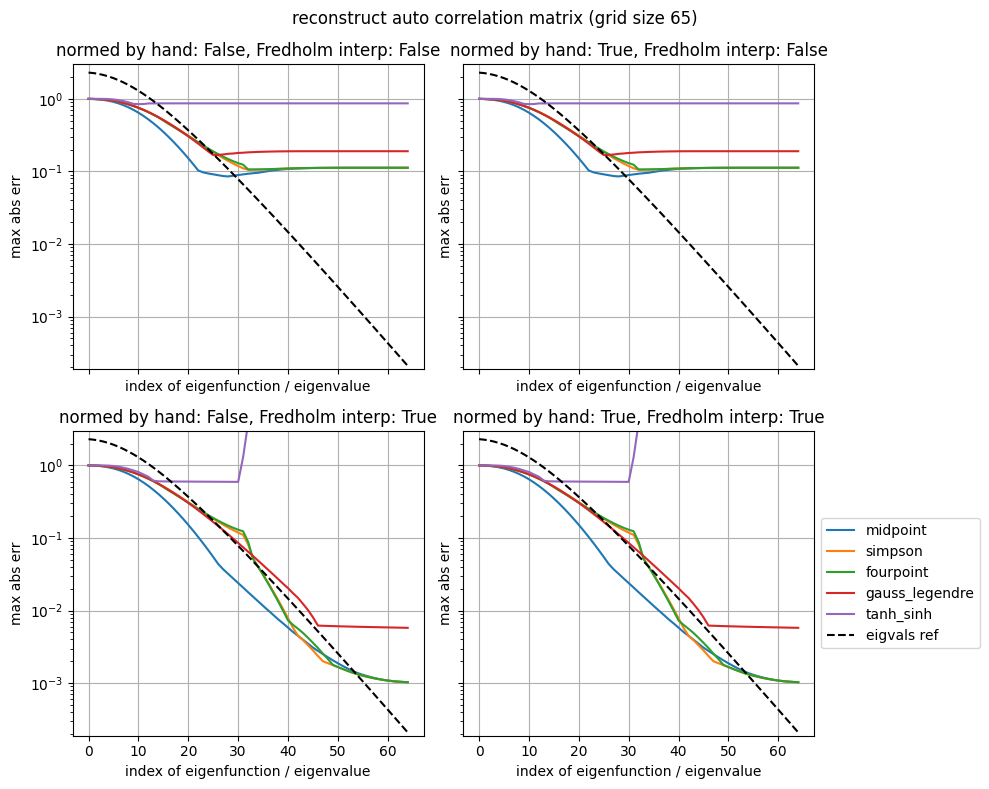

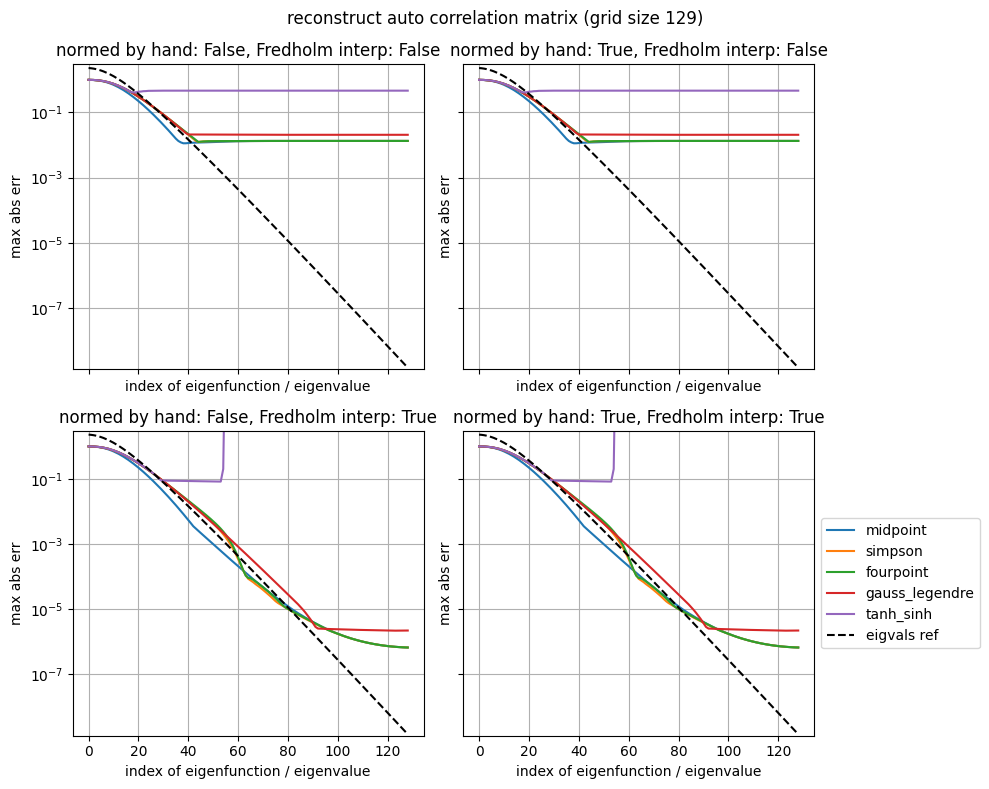

In [10]:
methods = [
    'midpoint',
    'simpson',
    'fourpoint',
    'gauss_legendre',
    'tanh_sinh',
]

for ng in [65, 129]:

    fig, ax = plt.subplots(
        ncols=2,
        nrows=2,
        figsize=(10, 8), 
        sharex=True,
        sharey=True,
    )
    
    for j1, fredholm_intp in enumerate([False, True]):
        for j2, normed_by_hand in enumerate([False, True]):
    
            axc = ax[j1, j2]

            for i, m in enumerate(methods):
                k_data, max_diff_data = calc_inp_acf_diff(
                    acf = acf,
                    t_max = t_max,
                    ng = ng,
                    quad_scheme = m,
                    t_fine_fac = 10,
                    normed_by_hand = normed_by_hand,
                    fredholm_intp = fredholm_intp,
                )
                axc.plot(k_data, max_diff_data, label=m)
                axc.set_yscale('log')
            axc.plot(eig_val_ref[:ng], color='k', ls='--', label="eigvals ref")
            #axc.set_xlim([-0.3, 5.3])
            axc.set_ylim([0.9*min(eig_val_ref[:ng]), 1.3*max(eig_val_ref[:ng])])
            axc.grid()
            axc.set_xlabel("index of eigenfunction / eigenvalue")
            axc.set_ylabel("max abs err")
            axc.set_title(f"normed by hand: {normed_by_hand}, Fredholm interp: {fredholm_intp}")
        
    axc.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    fig.suptitle(f"reconstruct auto correlation matrix (grid size {ng})")
    fig.tight_layout()


**Conclusion 1:** Fredholm interpolation is usefull to get the most out of the discrete solutions (as expected)

**Conclusion 2:** The advantage of the tanh-sinh seen by the on-grid comparison is blown away, most likely due to the large spacing of the inhomogeneous grid in the middle of the interval. The Fredholm interpolation, with or without by-hand-normalization of the eigen functions does not overcome that problem. (*I still think there could be an error in the code somewhere*, but I stop for now)

**FINAL CONCLUSION:** The most naiive **mid-point quadrature scheme** (equal weights) appreas to be slightly better compared to the other approached. Thus, it is the default setting for the Karhunen-Loeve expansion approach to sample stochastic processes.